
# Experiment II

This second experiment will try to increase the test accuracy apply rotation augmentation.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importing packages

Let's start by importing required packages:

* os — to read files and directory structure
* numpy — for some matrix math outside of TensorFlow
* matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [3]:
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

To build our image classifier, we begin by unzipping the dataset.

In [7]:
root_path = '/content/drive/MyDrive/DataSets'
os.chdir(root_path)

We can list the directories with the following terminal command:

In [8]:
dir = '/content/drive/MyDrive/DataSets/chest_xray'
zip_dir_base = os.path.dirname(dir)
!find $zip_dir_base -type d -print

/content/drive/MyDrive/DataSets
/content/drive/MyDrive/DataSets/chest_xray
/content/drive/MyDrive/DataSets/chest_xray/test
/content/drive/MyDrive/DataSets/chest_xray/test/PNEUMONIA
/content/drive/MyDrive/DataSets/chest_xray/test/NORMAL
/content/drive/MyDrive/DataSets/chest_xray/train
/content/drive/MyDrive/DataSets/chest_xray/train/NORMAL
/content/drive/MyDrive/DataSets/chest_xray/train/PNEUMONIA
/content/drive/MyDrive/DataSets/chest_xray/val
/content/drive/MyDrive/DataSets/chest_xray/val/NORMAL
/content/drive/MyDrive/DataSets/chest_xray/val/PNEUMONIA
/content/drive/MyDrive/DataSets/__MACOSX
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/test
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/test/PNEUMONIA
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/train
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/train/PNEUMONIA
/content/drive/MyDrive/DataSets/__MACOSX/chest_xray/train/NORMAL


We'll now assign variables with the proper file path for the training and test sets.

In [9]:
base_dir = os.path.join(os.path.dirname(dir), 'chest_xray')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

Let's look at how many normal and pneumonia images we have in our training, validation and test directory.

In [10]:
def get_total_chest_xray(category, source):
  """
  INPUT
  category: data set category, which could be 'training', 'test' and 'validation'
  source: a directory path.

  OUTPUT
  num_normal: total number of pictures
  num_pneumonia: 
  total: 

  DESCRIPTION
  This function move X (amount) random pictures from a source folder
  to destination folder.
  """
  source_normal = os.path.join(source, 'NORMAL') 
  source_pneumonia = os.path.join(source, 'PNEUMONIA')

  num_normal = len(os.listdir(source_normal))
  num_pneumonia = len(os.listdir(source_pneumonia))
  total = num_normal + num_pneumonia

  print('Total {}: {}'.format(category, total))
  print('total {} normal images: {}'.format(category, num_normal))
  print('total {} pneumonia images: {}'.format(category, num_pneumonia))

  return num_normal, num_pneumonia, total

In [11]:
num_normal_tr, num_pneumonia_tr, total_train = get_total_chest_xray('training', train_dir)

Total training: 3515
total training normal images: 979
total training pneumonia images: 2536


In [12]:
num_normal_test, num_pneumonia_test, total_test = get_total_chest_xray('test', test_dir)

Total test: 1171
total test normal images: 302
total test pneumonia images: 869


In [13]:
num_normal_val, num_pneumonia_val, total_val = get_total_chest_xray('validation', val_dir)

Total validation: 1171
total validation normal images: 302
total validation pneumonia images: 869


## Setting Model Parameters

Let's specify some model parameters.

In [14]:
BATCH_SIZE = 100  # Specifies how many training examples we feed our model before we update it's weight and bias variables
IMG_SHAPE  = 150  # Specifies the width and height in pixels to help the model process the images using a single input size

# Data Augmentation


We will apply rotation to our training set to augment the dataset to get a more chest X-ray variety to help us prevent overfitting and maybe achieve greater final accuracy. We'll use rotations of 20 degrees.

In [15]:
train_image_generator = ImageDataGenerator(
                                          rescale=1./255, 
                                          rotation_range=20)  # Generator for our training data
                                          
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data
test_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our test data

The batch size specifies that we should read a 100 images at a time, then we specifies the directory of the train ou validation set to be readed. The shufle parameter when set as True, will randomize the order of the images to the model does not start to memorize the order. Since our model can only process a specific input size, we specify a target_size parameter with the width and the height to resize the images to 150 x 150. The class_mode is binary since we just have two categories: Pneumonia or Normal.

In [16]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 3515 images belonging to 2 classes.


In [17]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=val_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1170 images belonging to 2 classes.


In [18]:
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 1171 images belonging to 2 classes.


## Visualizing Training images

Let's get a batch of images from the training generator to visualize a few of them using `matplotlib`.

In [19]:
sample_training_images, _ = next(train_data_gen)

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

In [20]:
def plotImages(images_arr, n_row, n_col):
    """
    INPUT:
    images_arr: a array of images

    DESCRIPTION:
    This function plot images in a grid with 5 row by 6 columns,
    plotting each image in a column
    """
    fig, axes = plt.subplots(n_row, n_col, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

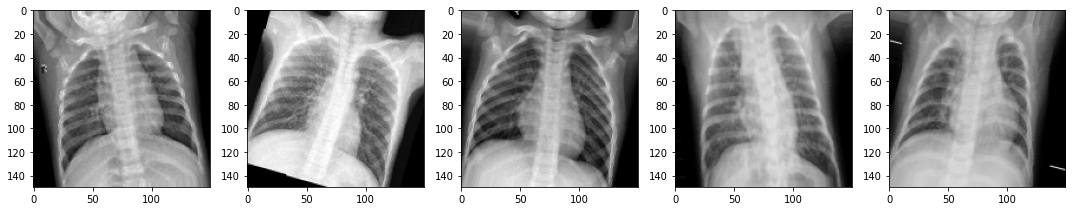

In [21]:
from random import random

visual_sample = [sample_training_images[int(random()*100)] for i in range(5)]
plotImages(visual_sample, 1, 5)

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them. We also use a dropout layer, which is another tecnique to help us avoid overfitting. This tecnique consists of randomly turn off some neurons as the data go through the epocs, which force other neurons to do all the job. The model will output class probabilities for two classes — Normal and Pneumonia — using softmax in the last layer.

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

## Compiling the model

We will use the adam optimizer, and keep up with training and validation accuracy on each epoch as we train our network.

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

Let's take a look at our model architecture!

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

## Train the model

It's time we train our network.

Since our batches are coming from a generator (ImageDataGenerator), we'll use fit_generator instead of fit.

In [25]:
EPOCHS = 50
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


36/36 [==============================] - 812s 23s/step - loss: 0.6148 - accuracy: 0.6893 - val_loss: 0.4951 - val_accuracy: 0.9034
Epoch 2/50
36/36 [==============================] - 66s 2s/step - loss: 0.3390 - accuracy: 0.8558 - val_loss: 0.1872 - val_accuracy: 0.9231
Epoch 3/50
36/36 [==============================] - 66s 2s/step - loss: 0.2433 - accuracy: 0.8973 - val_loss: 0.1599 - val_accuracy: 0.9410
Epoch 4/50
36/36 [==============================] - 66s 2s/step - loss: 0.2098 - accuracy: 0.9161 - val_loss: 0.1377 - val_accuracy: 0.9521
Epoch 5/50
36/36 [==============================] - 68s 2s/step - loss: 0.1884 - accuracy: 0.9246 - val_loss: 0.1107 - val_accuracy: 0.9590
Epoch 6/50
36/36 [==============================] - 68s 2s/step - loss: 0.1701 - accuracy: 0.9320 - val_loss: 0.1478 - val_accuracy: 0.9427
Epoch 7/50
36/36 [==============================] - 67s 2s/step - loss: 0.1490 - accuracy: 0.9388 - val_loss: 0.1138 - val_accuracy: 0.9590
Epoch 8/50
36/36 [===========

# Evaluate accuracy

Next, compare how the model performs on the test dataset. Use all examples we have in the test dataset to assess accuracy.

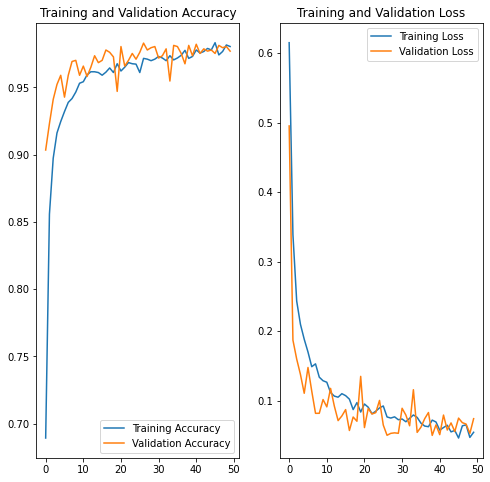

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are very close, which is a indication that the model is not overfitting, and model has achieved around 97% accuracy on the validation set (depending on the number of epochs you trained for).

In [27]:
import math
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=math.ceil(total_test/BATCH_SIZE))
print('Accuracy on test dataset:', test_accuracy)

12/12 [==============================] - 380s 34s/step - loss: 0.4389 - accuracy: 0.9009
Accuracy on test dataset: 0.9009393453598022


As it turns out, the accuracy on the test dataset is smaller than the accuracy on the training dataset. This is completely normal, since the model was trained on the train_dataset. When the model sees images it has never seen during training, (that is, from the test_dataset), we can expect performance to go down.

In [28]:
import joblib

def save_model(model, model_filepath):
    """
    INPUT
        model - a trained model
        model_filepath - a file path to store the trained model
    """
    joblib.dump(model, model_filepath)

In [29]:
save_model(model, 'chest-xray-classifier-II.pkl')